# Import Libraries

In [29]:
import os
import shap
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers, regularizers

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

In [30]:
shape_of_images = pd.read_csv('/kaggle/input/shape-and-size-of-the-data/image_shapes.csv')

In [31]:
shape_of_images#check the size of images dataset

,Image Name,Height,Width,Channels
0,ef476be214d4.png,614,819,3
1,6dcde47060f9.png,2136,3216,3
2,ec363f48867b.png,1958,2588,3
3,17f6c7072f61.png,1050,1050,3
4,b49b2fac2514.png,2588,3388,3
...,...,...,...,...
3657,215d2b7c3fde.png,614,819,3
3658,8b079e79035f.png,1050,1050,3
3659,c38dec54a9f7.png,1050,1050,3
3660,501c319f7a9f.png,1050,1050,3


# Load the data

In [32]:
train = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/test.csv')
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])

# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


# Model Parameters

In [34]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 10
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 400
WIDTH = 400
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

# Image Preprocessing

In [36]:
import tensorflow as tf
import cv2

def preprocess_image(image):
    #Custom preprocessing function for image generators.
    #Applies Gaussian blur and resizes the image to 400x400 pixels.
    # Convert image to numpy array (if it's a TensorFlow tensor)
    if isinstance(image, tf.Tensor):
        image = image.numpy()

    # Apply Gaussian blur (kernel size of 5x5)
    image = cv2.GaussianBlur(image, (5, 5), 0)

    # Resize the image to 400x400
    image = cv2.resize(image, (400, 400))

    # Normalize the image to the range [0, 1]
    image = image / 255.0
    
    return image

# Train test split

In [37]:
#X_train, X_val = train_test_split(train, test_size=0.2, random_state=123)
X_train, X_test = train_test_split(train, test_size=0.2, random_state=123)

# Data Generator

In [38]:
train_datagen=ImageDataGenerator( 
                                 rotation_range=360,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 validation_split=0.1,
                                 preprocessing_function=preprocess_image)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory="/kaggle/input/aptos2019-blindness-detection/train_images",
    x_col="id_code",
    y_col="diagnosis",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    target_size=(HEIGHT,WIDTH),
    seed=0,
    subset='training')

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory="/kaggle/input/aptos2019-blindness-detection/train_images",
    x_col="id_code",
    y_col="diagnosis",
    class_mode="categorical", 
    batch_size=BATCH_SIZE,   
    target_size=(HEIGHT,WIDTH),
    seed=0,
    subset= 'validation')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=X_test,
        directory = "/kaggle/input/aptos2019-blindness-detection/train_images",
        x_col="id_code",
        y_col="diagnosis",
        batch_size=1,
        class_mode="categorical",
        shuffle=False,
        target_size=(HEIGHT, WIDTH),
        seed=0)

Found 2637 validated image filenames belonging to 5 classes.
Found 292 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


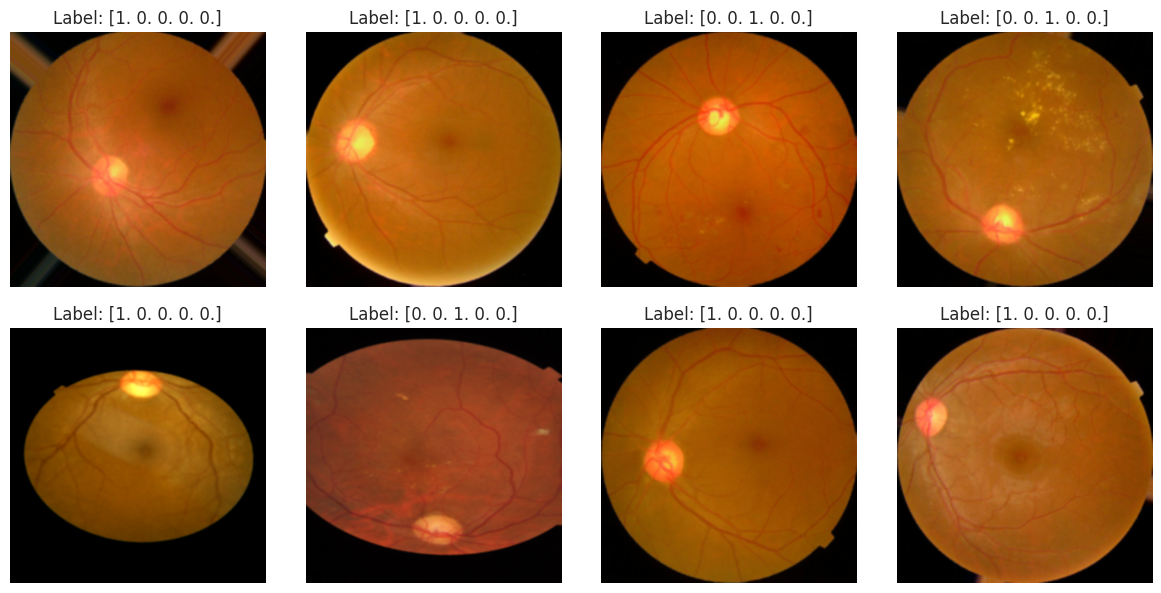

In [39]:
# Get a batch of images from the training generator
images, labels = next(train_generator)

# Plot the images
plt.figure(figsize=(12, 12))
for i in range(len(images)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [40]:
# Get a batch of images and labels from the train generator
images, labels = next(train_generator)

# Print the shape of the images and labels batch
print("Shape of images:", images.shape)
print("Shape of labels:", labels.shape)


Shape of images: (8, 400, 400, 3)
Shape of labels: (8, 5)


# Model

In [42]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    
    # Use EfficientNetB0 as the base model instead of ResNet50
    base_model = EfficientNetB0(weights='imagenet', 
                                include_top=False,
                                input_tensor=input_tensor)
    
    # Add global average pooling and dense layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.7)(x)
    x = Dense(2048, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)  # Fully connected layer
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)  # Output layer for classification
    
    # Create the model
    model = Model(inputs=input_tensor, outputs=final_output)
    
    return model

In [43]:
# Define the model
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

# Freeze all layers initially
for layer in model.layers:
    layer.trainable = False

# Unfreeze the last 5 layers for fine-tuning
for i in range(-5, 0):
    model.layers[i].trainable = True

# Compute class weights to handle imbalanced data
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train['diagnosis'].astype('int').values), 
    y=train['diagnosis'].astype('int').values
)

# Compile the model with Adam optimizer and categorical cross-entropy loss
metric_list = ["accuracy"]
optimizer = optimizers.Adam(learning_rate=WARMUP_LEARNING_RATE)  # Ensure the correct learning rate is used
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metric_list)

# Print the model summary
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 400, 400,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 400, 400,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 400, 400,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 400, 400,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 401, 401,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 200, 200,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 200, 200,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 200, 200,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 200, 200,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 200, 200,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 200, 200,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 200, 200,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 200, 200,  │        512 │ block1a_se_excit

 Total params: 6,683,304 (25.49 MB)

 Trainable params: 2,633,733 (10.05 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [44]:
# Define steps per epoch
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

In [46]:
from sklearn.utils import class_weight
# Compute class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train['diagnosis'].astype('int').values),
    y=train['diagnosis'].astype('int').values
)

# Create a class weights dictionary
class_weights_dict = {i: class_weights_array[i] for i in range(len(class_weights_array))}

# Define steps per epoch
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

# Fit the model
history_warmup = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=WARMUP_EPOCHS,
    class_weight=class_weights_dict,  # Use the dictionary here
    verbose=1
).history


Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 485s 1s/step - accuracy: 0.2227 - loss: 6.2471 - val_accuracy: 0.0833 - val_loss: 1.7583
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.0000e+00 - loss: 1.4791 - val_accuracy: 0.0000e+00 - val_loss: 1.7501
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 386s 1s/step - accuracy: 0.1521 - loss: 1.7475 - val_accuracy: 0.0312 - val_loss: 1.6419
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3750 - loss: 2.0955 - val_accuracy: 0.0000e+00 - val_loss: 1.6370
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - accuracy: 0.2074 - loss: 1.6441 - val_accuracy: 0.2465 - val_loss: 1.6242
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1250 - loss: 0.8002 - val_accuracy: 0.2500 - val_loss: 1.6278
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - accuracy: 0.1268 - loss: 1.6412 - val_accuracy: 0.0312 - val_loss: 1.6293
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 1.53

# Fine tune the complete model


In [47]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=metric_list)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 400, 400,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 400, 400,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 400, 400,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 400, 400,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 401, 401,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 200, 200,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 200, 200,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 200, 200,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 200, 200,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 200, 200,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 200, 200,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 200, 200,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 200, 200,  │        512 │ block1a_se_excit

 Total params: 6,683,304 (25.49 MB)

 Trainable params: 6,641,281 (25.33 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [49]:
history_finetunning = model.fit(train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          class_weight=class_weights_dict,
                                          verbose=1).history

Epoch 1/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - accuracy: 0.7529 - loss: 0.8748 - val_accuracy: 0.7708 - val_loss: 0.5376 - learning_rate: 1.0000e-04
Epoch 2/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.8750 - loss: 0.4071 - val_accuracy: 0.5000 - val_loss: 0.6890 - learning_rate: 1.0000e-04
Epoch 3/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 385s 1s/step - accuracy: 0.7678 - loss: 0.8351 - val_accuracy: 0.7882 - val_loss: 0.5388 - learning_rate: 1.0000e-04
Epoch 4/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8750 - loss: 0.9243 - val_accuracy: 1.0000 - val_loss: 0.0676 - learning_rate: 1.0000e-04
Epoch 5/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - accuracy: 0.7520 - loss: 0.8809 - val_accuracy: 0.8264 - val_loss: 0.4878 - learning_rate: 1.0000e-04
Epoch 6/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5000 - loss: 0.7515 - val_accuracy: 0.7500 - val_loss: 0.3371 - learning_rate: 1.0000e-04
Epoch 7/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accura

# Model loss Graph

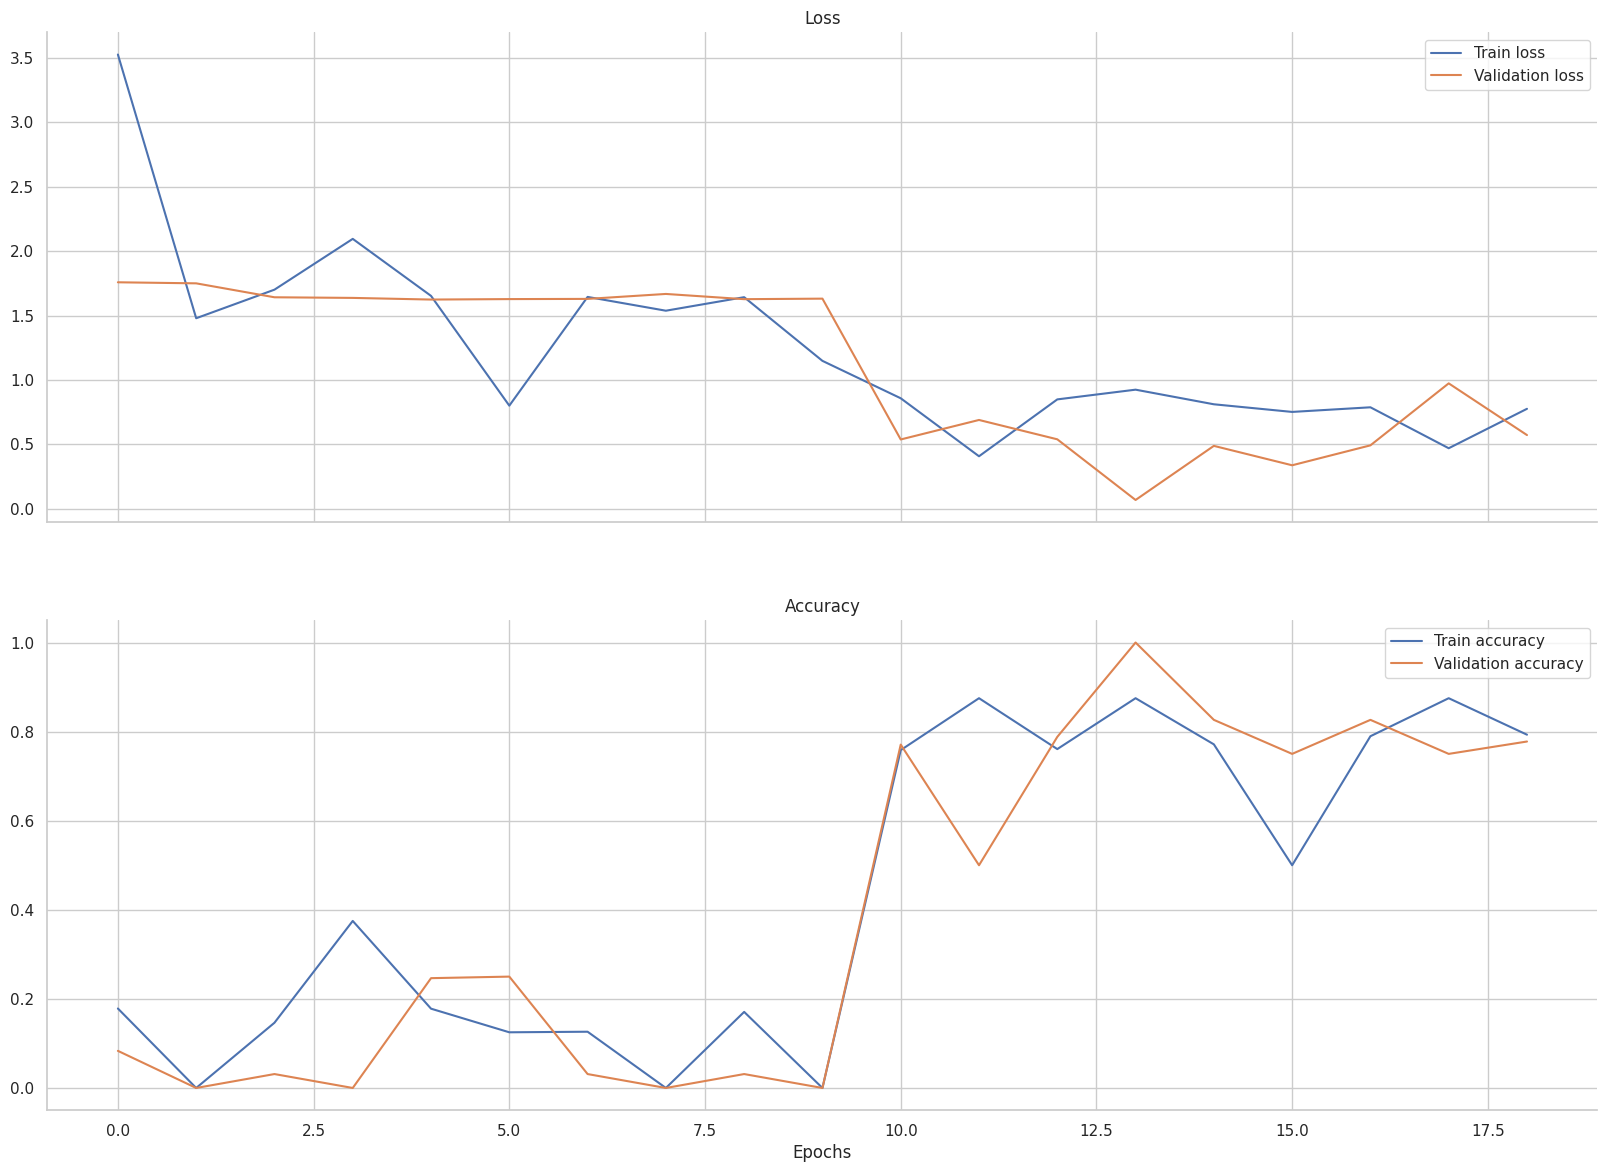

In [50]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'], 
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'], 
           'accuracy': history_warmup['accuracy'] + history_finetunning['accuracy'], 
           'val_accuracy': history_warmup['val_accuracy'] + history_finetunning['val_accuracy']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['accuracy'], label='Train accuracy')
ax2.plot(history['val_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

# Model Evaluation 

In [51]:
# Create empty arays to keep the predictions and labels
lastFullTrainPred = np.empty((0, N_CLASSES))
lastFullTrainLabels = np.empty((0, N_CLASSES))
lastFullValPred = np.empty((0, N_CLASSES))
lastFullValLabels = np.empty((0, N_CLASSES))

# Add train predictions and labels
for i in range(STEP_SIZE_TRAIN+1):
    im, lbl = next(train_generator)
    scores = model.predict(im, batch_size=train_generator.batch_size)
    lastFullTrainPred = np.append(lastFullTrainPred, scores, axis=0)
    lastFullTrainLabels = np.append(lastFullTrainLabels, lbl, axis=0)

# Add validation predictions and labels
for i in range(STEP_SIZE_VALID+1):
    im, lbl = next(valid_generator)
    scores = model.predict(im, batch_size=valid_generator.batch_size)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
    
    
lastFullComPred = np.concatenate((lastFullTrainPred, lastFullValPred))
lastFullComLabels = np.concatenate((lastFullTrainLabels, lastFullValLabels))
complete_labels = [np.argmax(label) for label in lastFullComLabels]

train_preds = [np.argmax(pred) for pred in lastFullTrainPred]
train_labels = [np.argmax(label) for label in lastFullTrainLabels]
validation_preds = [np.argmax(pred) for pred in lastFullValPred]
validation_labels = [np.argmax(label) for label in lastFullValLabels]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━

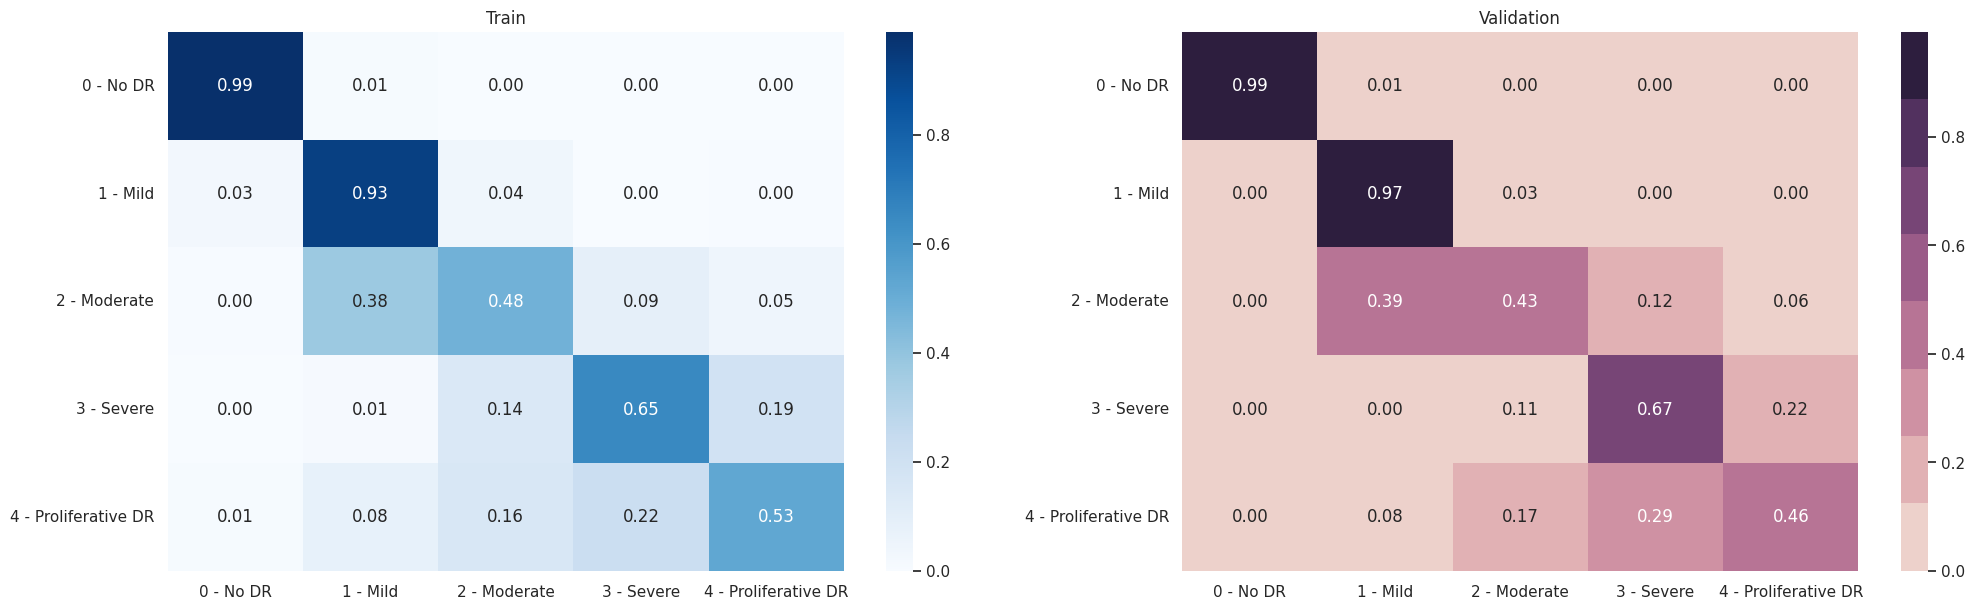

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
train_cnf_matrix = confusion_matrix(train_labels, train_preds)
validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds)

train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax1).set_title('Train')
sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap=sns.cubehelix_palette(8), ax=ax2).set_title('Validation')
plt.show()

# Quadratic Weighted Kappa

In [53]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds,train_labels, weights='quadratic'))
print("Validation Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds, validation_labels, weights='quadratic'))
print("Complete set Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds+validation_preds, train_labels+validation_labels, weights='quadratic'))

Train Cohen Kappa score: 0.890
Validation Cohen Kappa score: 0.891
Complete set Cohen Kappa score: 0.890


In [25]:
from tensorflow.keras.models import load_model

# Load the model from the output directory
model_loaded = load_model('/kaggle/input/efficient-model-400x400-top-model/tensorflow2/default/1/top efficient B0 multi.h5')  # Adjust path if necessary

# Verify that the model is loaded
model_loaded.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 400, 400,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 400, 400,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 400, 400,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 400, 400,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 401, 401,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 200, 200,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 200, 200,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 200, 200,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 200, 200,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 200, 200,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 200, 200,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 200, 200,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 200, 200,  │        512 │ block1a_se_excit

 Total params: 6,683,306 (25.49 MB)

 Trainable params: 6,641,281 (25.33 MB)

 Non-trainable params: 42,023 (164.16 KB)

 Optimizer params: 2 (12.00 B)

# Evalution On Test Data

In [54]:
# Example: Use model to make predictions on test data
test_loss, test_acc = model.evaluate(test_generator)
print("Test accuracy:", test_acc)

# Make predictions
predictions = model.predict(test_generator)


733/733 ━━━━━━━━━━━━━━━━━━━━ 97s 127ms/step - accuracy: 0.7550 - loss: 0.6542
Test accuracy: 0.7380627393722534
733/733 ━━━━━━━━━━━━━━━━━━━━ 81s 103ms/step


In [55]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

733/733 ━━━━━━━━━━━━━━━━━━━━ 75s 103ms/step - accuracy: 0.7550 - loss: 0.6542
733/733 ━━━━━━━━━━━━━━━━━━━━ 76s 103ms/step


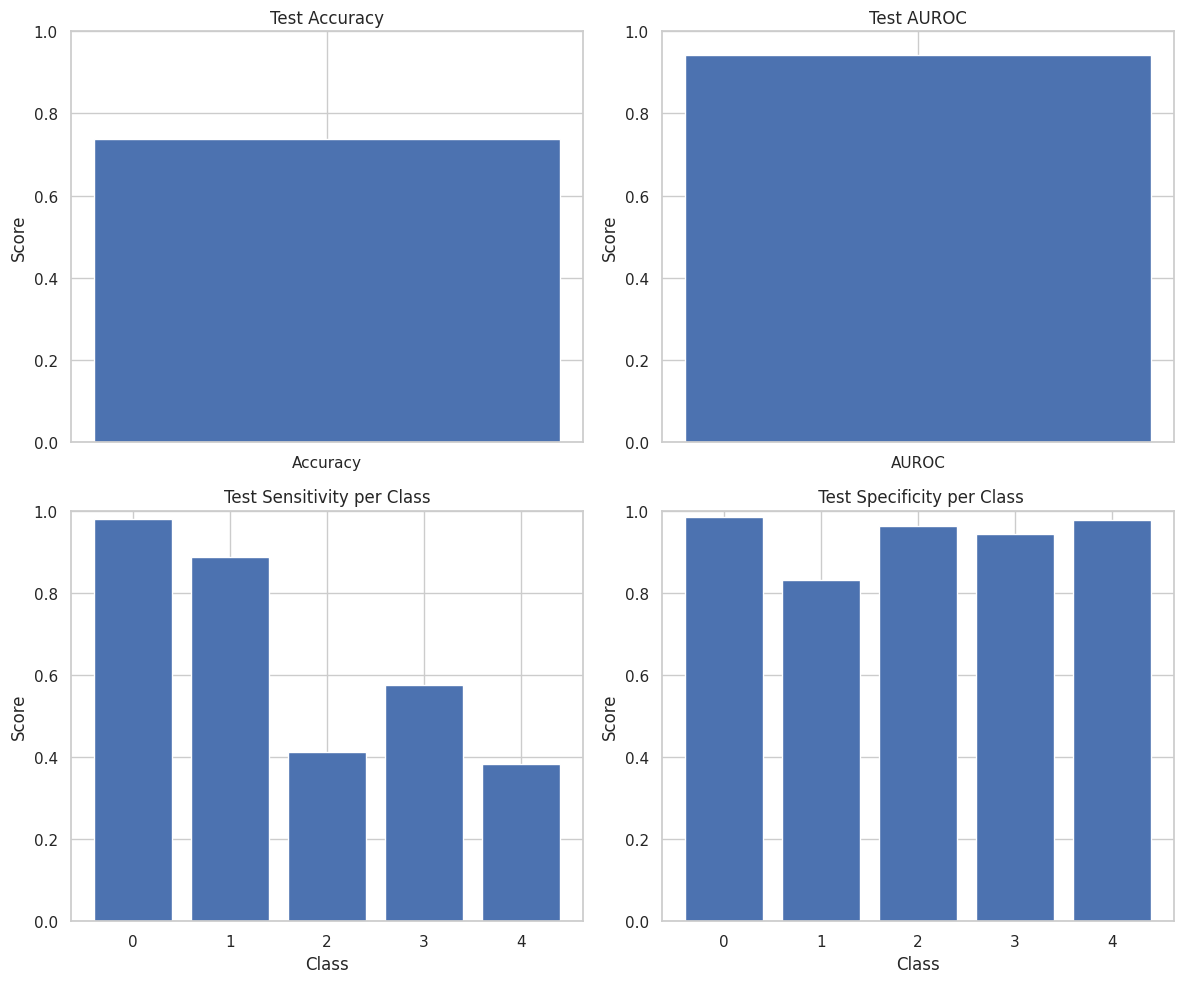

Overall Sensitivity: 0.65
Overall Specificity: 0.94


In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix
import numpy as np
import tensorflow as tf

# Evaluate on validation data
loss, acc = model.evaluate(test_generator, verbose=1)

# Get predictions on validation data
test_predictions = model.predict(test_generator)

# Convert predictions to class labels
test_predicted_classes = np.argmax(test_predictions, axis=1)

# Get the true labels from the validation generator
test_true_labels = test_generator.classes

# Accuracy
accuracy = accuracy_score(test_true_labels, test_predicted_classes)

# AUROC (for multi-class, one-vs-rest approach)
auroc = roc_auc_score(tf.keras.utils.to_categorical(test_true_labels, num_classes=5), test_predictions, multi_class='ovr')

# Sensitivity (recall)
sensitivity = recall_score(test_true_labels, test_predicted_classes, average=None)

# Specificity from confusion matrix
cm = confusion_matrix(test_true_labels, test_predicted_classes)
specificity = []
for i in range(len(cm)):
    tn = sum(sum(cm)) - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity.append(tn / (tn + fp))


# Overall Sensitivity (macro-average recall)
overall_sensitivity = np.mean(sensitivity)

# Overall Specificity
overall_specificity = np.mean(specificity)

# Plotting Accuracy, AUROC, Sensitivity, and Specificity

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Accuracy plot
axs[0, 0].bar(["Accuracy"], [accuracy])
axs[0, 0].set_ylim([0, 1])
axs[0, 0].set_title("Test Accuracy")
axs[0, 0].set_ylabel("Score")

# AUROC plot
axs[0, 1].bar(["AUROC"], [auroc])
axs[0, 1].set_ylim([0, 1])
axs[0, 1].set_title("Test AUROC")
axs[0, 1].set_ylabel("Score")

# Sensitivity plot (per class)
axs[1, 0].bar(np.arange(len(sensitivity)), sensitivity)
axs[1, 0].set_ylim([0, 1])
axs[1, 0].set_title("Test Sensitivity per Class")
axs[1, 0].set_ylabel("Score")
axs[1, 0].set_xlabel("Class")

# Specificity plot (per class)
axs[1, 1].bar(np.arange(len(specificity)), specificity)
axs[1, 1].set_ylim([0, 1])
axs[1, 1].set_title(" Test Specificity per Class")
axs[1, 1].set_ylabel("Score")
axs[1, 1].set_xlabel("Class")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


# Print overall sensitivity and specificity
print(f"Overall Sensitivity: {overall_sensitivity:.2f}")
print(f"Overall Specificity: {overall_specificity:.2f}")

In [57]:
print('auroc score for test data:',auroc)
print('sensitivity score for test data:',sensitivity)
print('specificity score for test data:',specificity)

auroc score for test data: 0.9432855032532765
sensitivity score for test data: [0.97982709 0.8875     0.41314554 0.57575758 0.38333333]
specificity score for test data: [0.9844559585492227, 0.8315467075038285, 0.9615384615384616, 0.9428571428571428, 0.9762258543833581]


# ROC Curve

In [58]:
import numpy as np
# Get the true labels and predicted probabilities from the test generator
test_labels = []
test_preds = []

# Loop through the test generator to get predictions and true labels
for i in range(STEP_SIZE_TEST):  # Adjust to match the number of test batches
    im, lbl = next(test_generator)  # Get a batch of images and labels
    scores = model.predict(im, batch_size=test_generator.batch_size)  # Predict probabilities
    test_preds.append(scores)  # Append predicted probabilities
    test_labels.append(lbl)  # Append true labels

# Convert lists to numpy arrays
test_preds = np.vstack(test_preds)  # Stack all predictions
test_labels = np.vstack(test_labels)  # Stack all true labels


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━

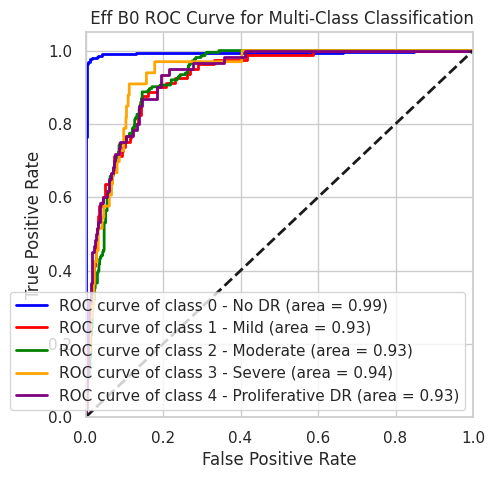

In [59]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Assuming you have 5 classes
n_classes = 5
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']

# Initialize dictionaries for False Positive Rate (fpr), True Positive Rate (tpr), and roc_auc
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], test_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(5, 5))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for a random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' Eff B0 ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

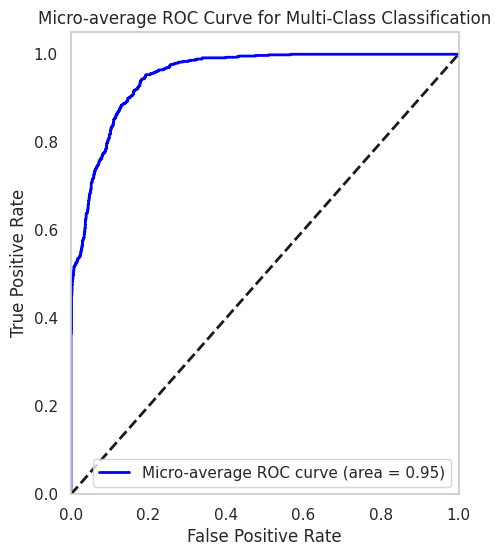

Micro-average AUC: 0.95


In [61]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the true labels and predicted probabilities from the test generator
test_labels = []
test_preds = []

# Loop through the test generator to get predictions and true labels
for i in range(STEP_SIZE_TEST):  # Adjust to match the number of test batches
    im, lbl = next(test_generator)  # Get a batch of images and labels
    scores = model.predict(im, batch_size=test_generator.batch_size)  # Predict probabilities
    test_preds.append(scores)  # Append predicted probabilities
    test_labels.append(lbl)  # Append true labels

# Convert lists to numpy arrays
test_preds = np.vstack(test_preds)  # Stack all predictions
test_labels = np.vstack(test_labels)  # Stack all true labels

# Assuming you have 5 classes
n_classes = 5

# Convert labels to binary format
# Create binary labels for the true labels
binary_labels = np.zeros((test_labels.shape[0], n_classes))
for i in range(test_labels.shape[0]):
    binary_labels[i, int(np.argmax(test_labels[i]))] = 1

# Calculate ROC curve and AUC for the micro-average
fpr, tpr, _ = roc_curve(binary_labels.ravel(), test_preds.ravel())
roc_auc = auc(fpr, tpr)

# Plot the micro-average ROC curve
plt.figure(figsize=(5, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for a random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.grid()  # Optional: add a grid for better readability
plt.show()

# Print the micro-average AUC
print(f'Micro-average AUC: {roc_auc:.2f}')


# Save model

In [63]:
model.save("top efficient B0 multi.h5")

# Multi Level Efficient 

In [64]:

from tensorflow.keras import layers, Model

In [65]:
# Load the EfficientNet-B0 base model without the top (fully connected) layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(400, 400, 3))

# Extracting features at different levels
block3_output = base_model.get_layer('block3a_expand_activation').output  # (32, 100, 100)
block5_output = base_model.get_layer('block5a_expand_activation').output  # (24, 50, 50)
block7_output = base_model.get_layer('block7a_expand_activation').output  # (40, 13, 13)

# Bilinear Interpolation to resize feature maps to (25x25)
block3_resized = layers.Lambda(lambda x: tf.image.resize(x, (25, 25), method='bilinear'))(block3_output)
block5_resized = layers.Lambda(lambda x: tf.image.resize(x, (25, 25), method='bilinear'))(block5_output)
block7_resized = layers.Lambda(lambda x: tf.image.resize(x, (25, 25), method='bilinear'))(block7_output)

# Apply 1x1 convolution to unify the channel depth across feature maps
block3_depth_adjusted = layers.Conv2D(320, (1, 1), padding='same', activation='relu')(block3_resized)
block5_depth_adjusted = layers.Conv2D(320, (1, 1), padding='same', activation='relu')(block5_resized)
block7_depth_adjusted = layers.Conv2D(320, (1, 1), padding='same', activation='relu')(block7_resized)

# Concatenate the resized and depth-adjusted feature maps
concatenated_features = layers.Concatenate()([block3_depth_adjusted, block5_depth_adjusted, block7_depth_adjusted])

# Apply a 1x1 convolution to reduce the depth of concatenated features
conv1x1 = layers.Conv2D(320, (1, 1), padding='same', activation='relu')(concatenated_features)

# Adaptive Average Pooling to reduce to (1, 1, 320)
adaptive_avg_pool = layers.GlobalAveragePooling2D()(conv1x1)

# Final fully connected layer for classification (5 classes as per your use case)
output = layers.Dense(5, activation='softmax')(adaptive_avg_pool)

# Create the final model
multi_level_efficientnet_b0 = Model(inputs=base_model.input, outputs=output)

# Compile the model
multi_level_efficientnet_b0.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to see the architecture
multi_level_efficientnet_b0.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 400, 400,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 400, 400,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 400, 400,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 400, 400,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 401, 401,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 200, 200,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 200, 200,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 200, 200,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 200, 200,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 200, 200,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 200, 200,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 200, 200,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 200, 200,  │        512 │ block1a_se_excit

 Total params: 4,016,568 (15.32 MB)

 Trainable params: 3,980,049 (15.18 MB)

 Non-trainable params: 36,519 (142.66 KB)

In [66]:
history_multi_level_efficientB0 = multi_level_efficientnet_b0.fit(train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          class_weight=class_weights_dict,
                                          verbose=1).history

Epoch 1/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 497s 1s/step - accuracy: 0.4631 - loss: 1.6547 - val_accuracy: 0.1042 - val_loss: 2.8166 - learning_rate: 0.0010
Epoch 2/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5000 - loss: 1.2490 - val_accuracy: 0.5000 - val_loss: 1.5540 - learning_rate: 0.0010
Epoch 3/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.5921 - loss: 1.1686 - val_accuracy: 0.1076 - val_loss: 2.6860 - learning_rate: 0.0010
Epoch 4/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7500 - loss: 1.0495 - val_accuracy: 0.2500 - val_loss: 3.0473 - learning_rate: 0.0010
Epoch 5/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.6602 - loss: 1.0223 - val_accuracy: 0.7986 - val_loss: 0.6168 - learning_rate: 0.0010
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


In [67]:
for layer in multi_level_efficientnet_b0.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
multi_level_efficientnet_b0.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=metric_list)
multi_level_efficientnet_b0.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 400, 400,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 400, 400,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 400, 400,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 400, 400,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 401, 401,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 200, 200,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 200, 200,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 200, 200,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 200, 200,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 200, 200,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 200, 200,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 200, 200,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 200, 200,  │        512 │ block1a_se_excit

 Total params: 4,016,568 (15.32 MB)

 Trainable params: 3,980,049 (15.18 MB)

 Non-trainable params: 36,519 (142.66 KB)

In [68]:
#fine tune model multi level efficient net B0
history_multi_level_efficientB0_finetune = multi_level_efficientnet_b0.fit(train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          class_weight=class_weights_dict,
                                          verbose=1).history

Epoch 1/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 490s 1s/step - accuracy: 0.6405 - loss: 1.0540 - val_accuracy: 0.0278 - val_loss: 27.5778 - learning_rate: 1.0000e-04
Epoch 2/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5000 - loss: 1.1688 - val_accuracy: 0.0000e+00 - val_loss: 12.0105 - learning_rate: 1.0000e-04
Epoch 3/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.7019 - loss: 0.9425 - val_accuracy: 0.5972 - val_loss: 0.8484 - learning_rate: 1.0000e-04
Epoch 4/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5000 - loss: 0.8680 - val_accuracy: 0.7500 - val_loss: 0.7711 - learning_rate: 1.0000e-04
Epoch 5/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.6871 - loss: 0.9411 - val_accuracy: 0.6979 - val_loss: 0.6151 - learning_rate: 1.0000e-04
Epoch 6/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6250 - loss: 1.3206 - val_accuracy: 1.0000 - val_loss: 0.2850 - learning_rate: 1.0000e-04
Epoch 7/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - 

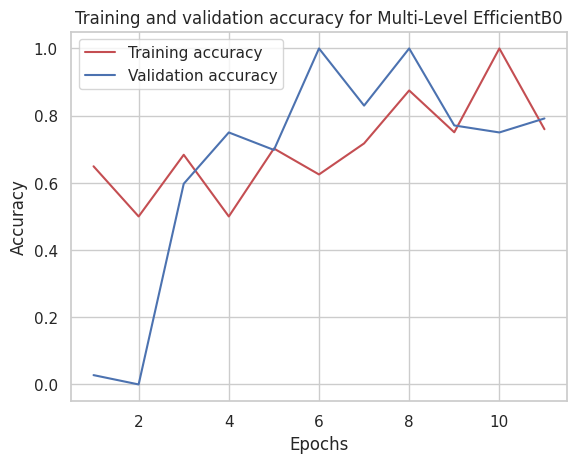

In [69]:
# Assuming 'history_multi_level_efficientB0' is a dictionary
epochs = range(1, len(history_multi_level_efficientB0_finetune["accuracy"]) + 1)
train_acc = history_multi_level_efficientB0_finetune["accuracy"]
val_acc = history_multi_level_efficientB0_finetune["val_accuracy"]

# Plotting the training and validation accuracy
import matplotlib.pyplot as plt

plt.figure()
plt.plot(epochs, train_acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy for Multi-Level EfficientB0")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


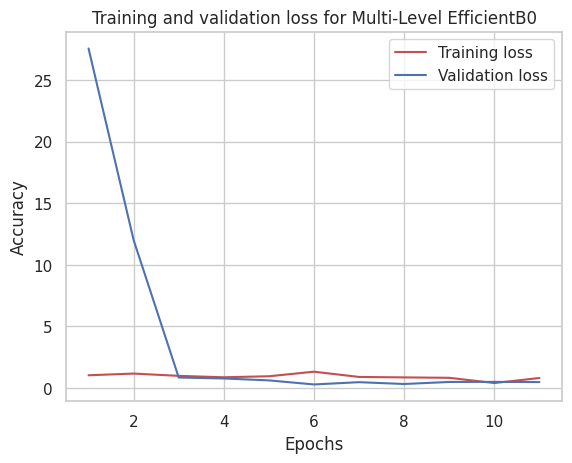

In [70]:
# Assuming 'history_multi_level_efficientB0' is a dictionary
epochs = range(1, len(history_multi_level_efficientB0_finetune["loss"]) + 1)
train_acc = history_multi_level_efficientB0_finetune["loss"]
val_acc = history_multi_level_efficientB0_finetune["val_loss"]

# Plotting the training and validation accuracy
import matplotlib.pyplot as plt

plt.figure()
plt.plot(epochs, train_acc, "r", label="Training loss")
plt.plot(epochs, val_acc, "b", label="Validation loss")
plt.title("Training and validation loss for Multi-Level EfficientB0")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [68]:
 multi_level_efficientnet_b0.save("top multi efficient B0 multi finetune.h5")

# Evaluate on test data

In [71]:
# Example: Use model to make predictions on test data
test_loss, test_acc = multi_level_efficientnet_b0.evaluate(test_generator)
print("Test accuracy:", test_acc)

# Make predictions
predictions_Ml = multi_level_efficientnet_b0.predict(test_generator)


733/733 ━━━━━━━━━━━━━━━━━━━━ 79s 104ms/step - accuracy: 0.6842 - loss: 0.6555
Test accuracy: 0.6889495253562927
733/733 ━━━━━━━━━━━━━━━━━━━━ 81s 103ms/step


In [72]:
#predictions using argmax
predicted_classes = np.argmax(predictions,axis=1)

In [73]:
true_labels = test_generator.classes

In [74]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

In [75]:
import numpy as np

# Get the true labels and predicted probabilities from the test generator
test_labels = []
test_preds = []

# Loop through the test generator to get predictions and true labels
for i in range(STEP_SIZE_TEST):  # Adjust to match the number of test batches
    im, lbl = next(test_generator)  # Get a batch of images and labels
    scores = multi_level_efficientnet_b0.predict(im, batch_size=test_generator.batch_size)  # Predict probabilities
    test_preds.append(scores)  # Append predicted probabilities
    test_labels.append(lbl)  # Append true labels

# Convert lists to numpy arrays
test_preds = np.vstack(test_preds)  # Stack all predictions
test_labels = np.vstack(test_labels)  # Stack all true labels


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━

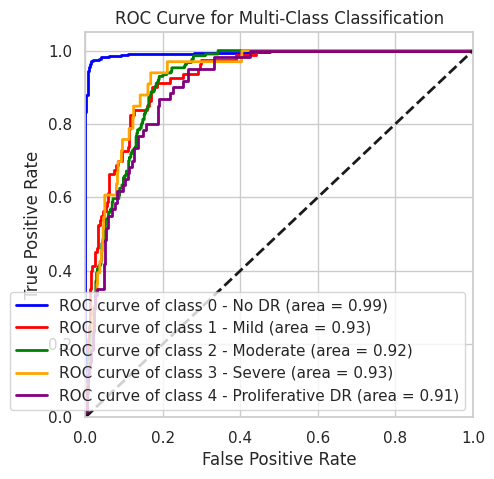

In [76]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Assuming you have 5 classes
n_classes = 5
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']

# Initialize dictionaries for False Positive Rate (fpr), True Positive Rate (tpr), and roc_auc
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], test_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(5, 5))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for a random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()


In [77]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the true labels and predicted probabilities from the test generator
test_labels = []
test_preds = []

# Loop through the test generator to get predictions and true labels
for i in range(STEP_SIZE_TEST):  # Adjust to match the number of test batches
    im, lbl = next(test_generator)  # Get a batch of images and labels
    scores = multi_level_efficientnet_b0.predict(im, batch_size=test_generator.batch_size)  # Predict probabilities
    test_preds.append(scores)  # Append predicted probabilities
    test_labels.append(lbl)  # Append true labels

# Convert lists to numpy arrays
test_preds = np.vstack(test_preds)  # Stack all predictions
test_labels = np.vstack(test_labels)  # Stack all true labels

# Assuming you have 5 classes
n_classes = 5

# Convert labels to binary format
# Create binary labels for the true labels
binary_labels = np.zeros((test_labels.shape[0], n_classes))
for i in range(test_labels.shape[0]):
    binary_labels[i, int(np.argmax(test_labels[i]))] = 1

# Calculate ROC curve and AUC for the micro-average
fpr, tpr, _ = roc_curve(binary_labels.ravel(), test_preds.ravel())
roc_auc = auc(fpr, tpr)

# Plot the micro-average ROC curve
plt.figure(figsize=(5, 6))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

<Figure size 500x600 with 0 Axes>

<Figure size 500x600 with 0 Axes>

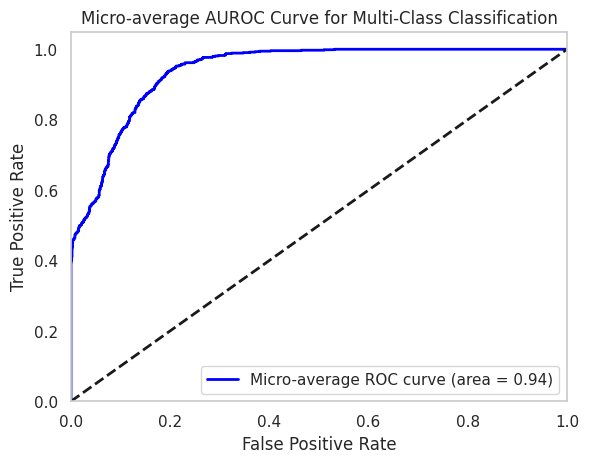

Micro-average AUC: 0.94


In [78]:

plt.plot(fpr, tpr, color='blue', lw=2, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for a random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average AUROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.grid()  # Optional: add a grid for better readability
plt.show()

# Print the micro-average AUC
print(f'Micro-average AUC: {roc_auc:.2f}')

In [79]:
print('auroc score for test data:',auroc)
print('specificity overall score for test data:',np.mean(specificity))
print('sensitivity overall score for test data:',np.mean(sensitivity))
print('specificity  score for test data:',specificity)
print('sensitivity  score for test data:',sensitivity)

auroc score for test data: 0.9432855032532765
specificity overall score for test data: 0.9393248249664028
sensitivity overall score for test data: 0.6479127076668376
specificity  score for test data: [0.9844559585492227, 0.8315467075038285, 0.9615384615384616, 0.9428571428571428, 0.9762258543833581]
sensitivity  score for test data: [0.97982709 0.8875     0.41314554 0.57575758 0.38333333]


In [80]:
#ensemble the model 
ensemble_model =np.mean([predictions,predictions_Ml],axis=0)

In [81]:
ensemble_final_preds = np.argmax(ensemble_model,axis=1)

In [82]:
ensemble_acc = accuracy_score(true_labels,ensemble_final_preds)

In [83]:
print("ensemble accuracy :",ensemble_acc)

ensemble accuracy : 0.723055934515689


Overall AUROC: 0.9432855032532765
Sensitivity per class: [0.97118156 0.8875     0.42253521 0.75757576 0.11666667]
Specificity per class: [0.9844559585492227, 0.8315467075038285, 0.9576923076923077, 0.9114285714285715, 0.9955423476968797]
Overall Sensitivity: 0.631091838341199
Overall Specificity: 0.9361331785741619


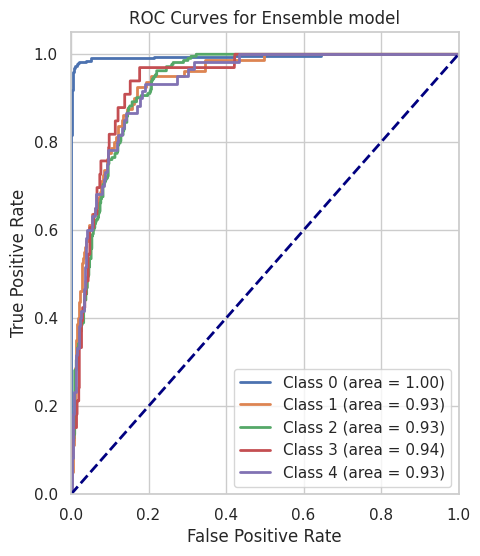

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc, recall_score, confusion_matrix
from sklearn.preprocessing import label_binarize


# Number of classes
num_classes = 5

# One-hot encode the true labels
true_labels_one_hot = label_binarize(true_labels, classes=[0, 1, 2, 3, 4])

# --- AUROC ---
# Calculate AUROC for each class using one-vs-rest approach
auroc_ens = roc_auc_score(true_labels_one_hot, ensemble_model, multi_class='ovr')
print(f"Overall AUROC: {auroc}")

# --- Sensitivity (Recall) ---
sensitivity_ens = recall_score(true_labels, ensemble_final_preds, average=None)
print(f"Sensitivity per class: {sensitivity_ens}")

# --- Specificity ---
# Calculate confusion matrix
cm = confusion_matrix(true_labels, ensemble_final_preds)
specificity_ens = []
for i in range(len(cm)):
    tn = sum(sum(cm)) - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity_ens.append(tn / (tn + fp))

print(f"Specificity per class: {specificity_ens}")

# Overall Sensitivity and Specificity
overall_sensitivity_ens = np.mean(sensitivity_ens)
overall_specificity_ens = np.mean(specificity_ens)

print(f"Overall Sensitivity: {overall_sensitivity_ens}")
print(f"Overall Specificity: {overall_specificity_ens}")

# --- ROC Curves for each class ---
# Plot ROC curves for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(5, 6))

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_one_hot[:, i], ensemble_model[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {i} (area = {roc_auc[i]:.2f})")

# Plot ROC curve for random guessing
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

# Plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Ensemble model")
plt.legend(loc="lower right")
plt.show()


Overall AUROC: 0.9450451326795779


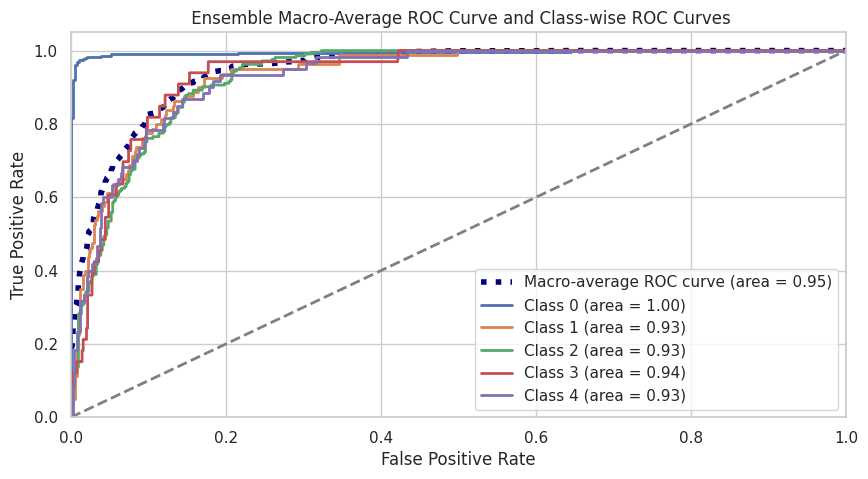

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# Assuming you have the following variables from your ensemble model
# `ensemble_model`: Probability predictions from the ensemble model
# `true_labels`: True class labels
num_classes = 5  # Number of classes in your classification problem

# One-hot encode the true labels
true_labels_one_hot = label_binarize(true_labels, classes=[0, 1, 2, 3, 4])

# --- Overall AUROC ---
# Calculate the macro-average AUROC score
overall_auroc = roc_auc_score(true_labels_one_hot, ensemble_model, average='macro', multi_class='ovr')
print(f"Overall AUROC: {overall_auroc}")

# --- Macro-average ROC Curve ---
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_one_hot[:, i], ensemble_model[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(true_labels_one_hot.ravel(), ensemble_model.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute the AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the macro-average ROC curve
plt.figure(figsize=(10, 5))
plt.plot(fpr["macro"], tpr["macro"],
         label=f"Macro-average ROC curve (area = {roc_auc['macro']:.2f})",
         color="navy", linestyle=":", linewidth=4)

# Plot ROC curve for random guessing
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")

# Plot individual class ROC curves (optional)
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {i} (area = {roc_auc[i]:.2f})")

# Plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(" Ensemble Macro-Average ROC Curve and Class-wise ROC Curves")
plt.legend(loc="lower right")
plt.show()


# TTA Implementation

# Note:
 While Test-Time Augmentation (TTA) typically yields the best results and improves accuracy, it requires significant GPU resources. Therefore, instead of using extensive data augmentation, I implemented only horizontal flipping (FLIP_LR). However, running this on my Kaggle environment is not feasible due to limited computational power.


Edafa is a Python wrapper designed to simplify the implementation of Test-Time Augmentation (TTA) for computer vision tasks. Test-Time Augmentation is a technique where, during model evaluation (testing), multiple augmentations of the input image are generated, and the model's predictions are averaged or fused to improve the final performance. This approach is particularly beneficial for tasks like segmentation, super-resolution, and pansharpening, as it can reduce overfitting, increase robustness, and provide better generalization to unseen data.

In [ ]:
!pip install edafa

In [ ]:
from edafa import ClassPredictor

In [ ]:
from tensorflow.keras.models import load_model
model_loaded = load_model('/kaggle/input/efficient-model-400x400-top-model/tensorflow2/default/1/top efficient B0 multi.h5')

In [ ]:
import numpy as np

class TTAPredictor:
    def __init__(self, model, config):
        self.model = model
        self.aug = config.get('aug', 'NO')  # Default to no augmentation
        self.mean = config.get('mean', 'ARITH')  # Default to arithmetic mean

    def augment_image(self, image):
        """Apply the selected augmentation to the image."""
        if self.aug == 'FLIP_LR':
            return np.flip(image, axis=2)  # Flip Left-Right
        return image  # Return the original if no augmentation
    
    def predict_tta(self, test_generator):
        """Predict with Test-Time Augmentation (TTA) using only FLIP_LR."""
        predictions = []

        for batch in test_generator:
            images, _ = batch  # Extract images, ignore labels

            # Apply augmentation and ensure the shape is consistent
            augmented_batch = np.array([self.augment_image(img) for img in images])
            assert augmented_batch.shape == images.shape, f"Shape mismatch: {augmented_batch.shape} vs {images.shape}"

            # Get predictions for the augmented images
            preds = self.model.predict(augmented_batch)
            predictions.append(preds)

        return np.concatenate(predictions, axis=0)

# Configuration for using only FLIP_LR augmentation
conf = {
    "aug": "FLIP_LR",
    "mean": "ARITH"  # Arithmetic mean for averaging predictions (if used in ensemble settings)
}

# Initialize TTA predictor with the model and config
tta_predictor = TTAPredictor(model_loaded, conf)

# Use the TTA predictor to get augmented predictions
y_pred_aug = tta_predictor.predict_tta(test_generator)


In [ ]:
ensemble_acc = accuracy_score(true_labels,ensemble_final_preds)

In [ ]:
TTA = accuracy_score(true_labels,ensemble_final_preds)